# triangle_data_structure

> Data structure for triangulation

See https://cs184.eecs.berkeley.edu/public/sp22/lectures/lec-8-mesh-representations-and-geometr/lec-8-mesh-representations-and-geometr.pdf

None of the methods below are optimized, and on many occasions, things are linear/quadratic in the mesh size even though they need not be, because it was the easiest solution

In [ ]:
#| default_exp triangle

In [ ]:
#| hide
from nbdev.showdoc import *
import nbdev

In [ ]:
#| export
import os
import numpy as np
import matplotlib.pyplot as plt
import matplotlib as mpl
from matplotlib.collections import LineCollection

from scipy import spatial

In [ ]:
#| export
from collections import defaultdict

In [ ]:
#| export

from dataclasses import dataclass
from typing import Union, Dict, List, Tuple, Iterable, Callable
from nptyping import NDArray, Int, Float, Shape

from fastcore.foundation import patch

## helper functions

In [ ]:
#| export
from bisect import bisect_left

In [ ]:
bisect_left([-1, 0, 1, 2], 1)

2

In [ ]:
#| export
def flatten(lst, max_depth=1000, iter_count=0):
    """
    Flatten a list of lists into a list.

    Also works with inhomogeneous lists, e.g., [[0,1],2]. The argument
    depth determines how "deep" to flatten the list, e.g. with max_depth=1:
    [[(1,0), (1,0)]] -> [(1,0), (1,0)].

    Parameters
    ----------
    lst : list
        list-of-lists.
    max_depth : int, optional
        To what depth to flatten the list.
    iter_count : int, optional
        Helper argument for recursion depth determination.
    Returns
    -------
    iterator
        flattened list.

    """
    for el in lst:
        if (isinstance(el, Iterable) and not isinstance(el, (str, bytes))
                and iter_count < max_depth):
            yield from flatten(el, max_depth=max_depth,
                               iter_count=iter_count+1)
        else:
            yield el

In [ ]:
#| export
def sort_vertices(vertices: np.ndarray) -> np.ndarray:
    """Sort vertices of cycle counter clockwise by polar angle. Guaranteed to work for non-convex polygons."""
    vertices -= np.mean(vertices, axis=0) # center
    phis = [np.arctan2(*x[::-1]) for x in vertices]
    return np.stack([x for _, x in sorted(zip(phis, vertices))])

def sort_ids_by_vertices(ids: Iterable[int], vertices: Iterable[NDArray]) -> list:
    """Like sort_vertices, sort ids of cycle counter clockwise by polar angle."""
    vertices -= np.mean(vertices, axis=0) # vertices
    phis = [np.arctan2(*x[::-1]) for x in vertices]
    return [x for _, x in sorted(zip(phis, ids))]

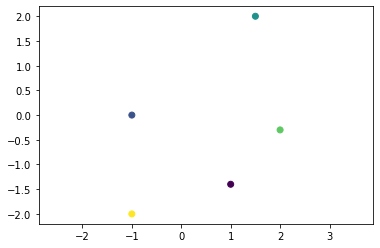

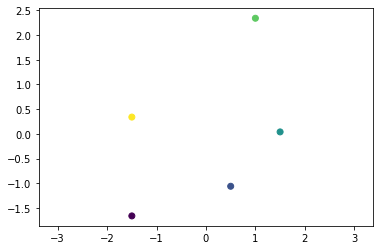

In [ ]:
pts = np.array([[1,-1.4], [-1, 0], [1.5, 2], [2, -.3], [-1, -2]])

plt.scatter(*pts.T, c=np.arange(5))
plt.axis("equal")
plt.show()

pts_sorted = sort_vertices(pts)

plt.scatter(*pts_sorted.T, c=np.arange(5))
plt.axis("equal")
plt.show()

## create some test data using scipy

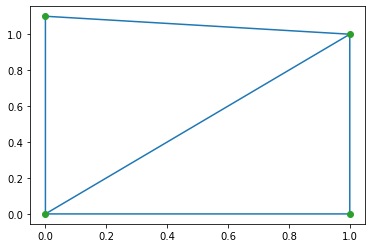

In [ ]:
points = np.array([[0, 0], [0, 1.1], [1, 0], [1, 1]])

tri = spatial.Delaunay(points)

plt.triplot(points[:,0], points[:,1], tri.simplices)
plt.plot(points[:,0], points[:,1], 'o')

plt.show()

In [ ]:
# attributes

tri.points, tri.simplices, tri.neighbors

(array([[0. , 0. ],
        [0. , 1.1],
        [1. , 0. ],
        [1. , 1. ]]),
 array([[2, 3, 0],
        [3, 1, 0]], dtype=int32),
 array([[ 1, -1, -1],
        [-1,  0, -1]], dtype=int32))

In [ ]:
# methods

tri.find_simplex, tri.add_points

(<bound method Delaunay.find_simplex of <scipy.spatial._qhull.Delaunay object>>,
 <bound method Delaunay.add_points of <scipy.spatial._qhull.Delaunay object>>)

## List of Pts + Triangles

Simplest data structure for a triangulation:

- Vertices = [($x_0$,$y_0$), ... ]
- Triangles = [(vertex id 1, vertex id 2, vertex id 3), ...]

From this data, one can compute the neighbor relationship of triangles
- Triangle neighbors = [(triangle id 1, triangle id 2, triangle id 3), ...]

How should we index things? We want to be able to refer to points and faces consistently over time series of meshes, so just using their index in the list is no good. We shall use dictionaries instead.

For future reference, we will make the faces oriented _counterclockwise_. This matches the convention of the `.obj` file format.

In [ ]:
#| export

def get_neighbors(faces):
    """compute neighbor list by checking which triangles share 2 vertices."""
    edge_dict = defaultdict(list)
    for key, fc in faces.items():
        edges = [tuple(sorted((fc+[fc[0]])[i:i+2])) for i in range(len(fc))]
        [edge_dict[e].append(key) for e in edges]

    neighbors = defaultdict(list)
    for edge, fcs in edge_dict.items():
        if len(fcs) == 2:
            neighbors[fcs[0]].append(fcs[1])
            neighbors[fcs[1]].append(fcs[0])
    return neighbors

In [ ]:
#| export

class ListOfVerticesAndFaces:
    def __init__(self, vertices, faces, neighbors=None):
        # if we pass lists, automatically assign ids to triangles and vertices
        vertices = vertices if type(vertices) is dict else {ix: x for ix, x in enumerate(vertices)}
        faces = faces if type(faces) is dict else {ix: x for ix, x in enumerate(faces)}
        # ensure that all triangles are ordered cc-wise
        faces = {key: sort_ids_by_vertices(fc, [vertices[x] for x in fc])
                 for key, fc in faces.items()}
        self.vertices, self.faces = (vertices, faces)
        self.neighbors = get_neighbors(faces) if neighbors is None else neighbors
        
    # some basic methods
    def remove_vertex(self, v_id):
        del self.vertices[v_id]
        self.faces = {key: face for key, face in self.faces.items() if not v_id in face}
        self.neighbors = get_neighbors(self.faces)
        
    def get_combined_edges(self):
        """Get a list of unique edges. Edges are a tuple ((vert 1, vert 2), (face 1, face 2)). Boundary edges 
        have face 1 None."""
        combined_edges = []
        for fc_key, fc in self.faces.items():
            neighbors = self.neighbors[fc_key]
            vertex_edges = [(fc+[fc[0]])[i:i+2] for i in range(len(fc))]
            for vertex_edge in vertex_edges:
                # check if it is shared with neighbor
                other_key = [nghb for nghb in neighbors if all([v in self.faces[nghb] for v in vertex_edge])]
                face_edge = sorted([fc_key, other_key[0]]) if other_key != [] else (None, fc_key)
                combined_edge = (tuple(sorted(vertex_edge)), tuple(face_edge))
                combined_edges.append(combined_edge)
        return set(combined_edges)
        
    @staticmethod
    def fromObj(fname):
        """Read from .onj file. If {fname}_ids.txt is present, read ids from that."""
        with open(fname+'.obj') as f:
            lns = f.readlines()
            vertices = [np.array([float(x) for x in ln[2:-1].split(" ")])[:2] # remove z-coord
                        for ln in lns if ln.startswith("v")]
            faces = [[int(x)-1 for x in ln[2:-1].split(" ")] # to start counting from 0 again
                      for ln in lns if ln.startswith("f")]
        if os.path.isfile(fname+'_ids.txt'): # read ids if defined
            with open(fname+'_ids.txt') as f:
                lns = f.readlines()
                vertex_ids = [int(ln[2:-1]) for ln in lns if ln.startswith("v")]
                face_ids = [int(ln[2:-1]) for ln in lns if ln.startswith("f")]
            vertices = {v_id: v for v_id, v in zip(vertex_ids, vertices)}
            faces = {fcid: fc for fcid, fc in zip(face_ids, faces)}
        return ListOfVerticesAndFaces(vertices, faces)

In [ ]:
#| export

def get_test_mesh():
    points = np.array([[0, 0], [0, 1.1], [1, 0], [1, 1]])
    tri = spatial.Delaunay(points)
    return ListOfVerticesAndFaces(tri.points, tri.simplices)

In [ ]:
test_mesh = get_test_mesh()

In [ ]:
test_mesh.faces

{0: [0, 2, 3], 1: [0, 3, 1]}

In [ ]:
test_mesh.vertices

{0: array([0., 0.]),
 1: array([0. , 1.1]),
 2: array([1., 0.]),
 3: array([1., 1.])}

In [ ]:
test_mesh.neighbors

defaultdict(list, {0: [1], 1: [0]})

In [ ]:
#| export
@patch
def saveObj(self:ListOfVerticesAndFaces, fname, save_ids=False):
    """save as obj file. .obj automatically appended to fname. If save_ids is True, also save a list
    of vertex and face ids."""
    # create a sorted list of vertices
    vertex_keys = sorted(self.vertices.keys())
    vertex_list = [self.vertices[key] for key in vertex_keys]
    # change faces list to refer to this ordered list. Counting from 1 for .obj
    face_keys = sorted(self.faces.keys())
    faces_list = [[bisect_left(vertex_keys, v)+1 for v in self.faces[key]] for key in face_keys]
    # overwrite
    try:
        os.remove(fname+".obj")
    except OSError:
        pass
    # write
    with open(fname+".obj", "a") as f:
        f.write('# vertices\n')
        for pt in vertex_list:
            to_write = ' '.join(['v'] + [str(x) for x in pt] + ['0']) + '\n'  # include z-ccoord
            f.write(to_write)
        f.write('# faces\n')
        for fc in faces_list:
            to_write = ' '.join(['f'] + [str(x) for x in fc]) + '\n'
            f.write(to_write)
    if save_ids:
        try:
            os.remove(fname+"_ids.txt")
        except OSError:
            pass
        with open(fname+"_ids.txt", "a") as f:
            f.write('# vertex IDs corresponding to .obj file\n')
            for key in vertex_keys:
                f.write('v '+str(key)+'\n')
            f.write('# face IDs corresponding to .obj file\n')
            for key in face_keys:
                f.write('f '+str(key)+'\n')


In [ ]:
test_mesh.saveObj('test_mesh', save_ids=True)
# tested by opening in paraview, looks good

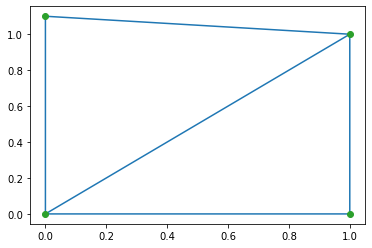

In [ ]:
loaded_mesh = test_mesh.fromObj('test_mesh')
loaded_mesh.faces, test_mesh.faces

({0: [0, 2, 3], 1: [0, 3, 1]}, {0: [0, 2, 3], 1: [0, 3, 1]})

In [ ]:
test_mesh = get_test_mesh()

print(test_mesh.faces, test_mesh.neighbors)

test_mesh.remove_vertex(1)

print(test_mesh.faces, test_mesh.neighbors)

{0: [0, 2, 3], 1: [0, 3, 1]} defaultdict(<class 'list'>, {0: [1], 1: [0]})
{0: [0, 2, 3]} defaultdict(<class 'list'>, {})


## Half-edge

More complicated operations (e.g. flipping triangles) are a pain to implement with this simple data structure, which furthermore does not contain edges. We now build a half-edge data structure class.

A half-edge contains the following data:
- `next` - the next half edge
- `twin` - the twin half edge
- `face` - the face it belongs to
- `vertices` - start and end vertex

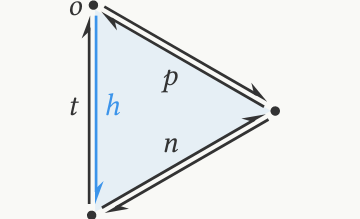
See https://jerryyin.info/geometry-processing-algorithms/half-edge/

In [ ]:
#| export
from dataclasses import dataclass, field

In [ ]:
#| export

@dataclass
class HalfEdge:
    """Attribute holder class for half edges. Attributes point to other items, property methods get them."""
    _heid : int
    _nxtid: int
    _previd: int
    _twinid: int
    _faceid: Union[int, None] # None if it's a boundary
    _verticesid: tuple # 0 is origin, 1 is destination
    rest: float = 0.
    passive: float = 0.
    flipped: int = 0
    variables: dict = field(default_factory=dict, repr=False) 
    _hemesh: int = field(default=None, repr=False) # set during creation of mesh
    duplicate: bool = False # arbitraily select half of all edges for future iteration convenience
    # set methods to get the twins, nxts, and prevs using the internal use _ids to look them up in the dict
    @property
    def nxt(self):
        return self._hemesh.hes[self._nxtid]
    @property
    def prev(self):
        return self._hemesh.hes[self._previd]
    @property
    def twin(self):
        return self._hemesh.hes[self._twinid]
    @property
    def face(self):
        if self._faceid is None:
            return None
        return self._hemesh.faces[self._faceid]
    @property
    def vertices(self):
        return [self._hemesh.vertices[v] for v in self._verticesid]
    def __post_init__(self):
        self.duplicate = self._verticesid[0] < self._verticesid[1]
        
    def __repr__(self):
        repr_str = f"HalfEdge(heid={self._heid}, nxt={self._nxtid}, prev={self._previd}, twin={self._twinid}, "
        if self._faceid is not None:
            repr_str += f"face={self._faceid}, "
        else:
            repr_str += f"face=None, "
        repr_str += f"vertices={self._verticesid}, "
        repr_str += f"rest={round(self.rest, ndigits=1)}, passive={round(self.passive, ndigits=1)}"
        if self._hemesh is not None:
            repr_str += f", center={np.round(np.mean([v.coords  for v in self.vertices], axis=0), decimals=1)}"
        return repr_str

    
@dataclass
class Vertex:
    """Attribute holder class for vertices. Attributes point to other items. Note: different from the
    standard half edge data structure, I store all incident he's, for latter convenience (e.g. force balance)
    computation."""
    _vid : int
    coords : NDArray[Shape["2"], Float]
    incident : List[HalfEdge]
    
    def __repr__(self):
        repr_str = f"Vertex(vid={self._vid}, coords={np.round(self.coords, decimals=1)}, "
        repr_str += f"hes={[he._heid for he in self.incident]})"
        return repr_str
        

@dataclass
class Face:
    """Attribute holder class for faces. Attributes point to other items."""
    _fid : int
    hes : List[HalfEdge]
    dual_coords: Union[NDArray[Shape["2"],Float], None] = None
    rest_shape: NDArray[Shape["2, 2"],Float] = np.array([[1.0, 0.0], [0.0, 1.0]])
    def __repr__(self):
        repr_str = f"Face(fid={self._fid}, "
        if self.dual_coords is not None:
            repr_str += f"dual_coords={list(np.round(self.dual_coords, decimals=1))}, "
        repr_str += f"rest_shape={[list(x) for x in np.round(self.rest_shape, decimals=1)]}, "
        repr_str += f"hes={[he._heid for he in self.hes]})"
        return repr_str


In [ ]:
he = HalfEdge(10031, 1, 2, 4, 2, (2, 3))

v = Vertex(10, np.array([2.0232, 2.1241]), [he])
he_new = HalfEdge(10034, 1, 2, 4, 2, (2, 3))

v.incident = [he_new] # we can edit the incident edge
v

Vertex(vid=10, coords=[2.  2.1], hes=[10034])

In [ ]:
v.incident == he_new, not (v.incident == he)

(False, True)

In [ ]:
#| export

@patch
def sort_hes(self: Face):
    """Sort the list of hes of a face."""
    sorted_hes = []
    returned = False
    start_he = self.hes[0]
    he = start_he
    while not returned:
        sorted_hes.append(he)
        if he._hemesh is not None:
            he = he.nxt
        else:
            he = next(x for x in self.hes if x._heid == he._nxtid)
        returned = (he == start_he)
    self.hes = sorted_hes

The additional data provided by the half-edge mesh structure will be very helpful further on. In order to initialize the half-edge data structure, we use the `ListOfVerticesAndFaces` class from above.

TO DO: figure out how to deal with edge id's, edge variables.

Everything has a lot more boilerplate unfortunately, because I am using `dict`s of objects, and not directly pointers like in a C++ implementation.

Inspired by: https://github.com/yig/trimesh/blob/master/trimesh.py

The first question is how to get the half-edges from the face-list.

In [ ]:
#| export
def get_half_edges(mesh: ListOfVerticesAndFaces) -> Dict[int, HalfEdge]:
    """Create list of half-edges from a ListOfVerticesAndFaces mesh"""
    heid_counter = 0
    he_vertex_dict = dict()
    # first create half edges without their twins by going around each face.
    # index them by their vertices to match twins after
    for key, fc in mesh.faces.items():
        # ensure face is oriented correctly
        fc = sort_ids_by_vertices(fc, [mesh.vertices[x] for x in fc])
        heids = [heid_counter+i for i in range(len(fc))]
        nxts, prevs = (np.roll(heids, -1).tolist(), np.roll(heids, +1).tolist())
        vertices = [tuple((fc+[fc[0]])[i:i+2]) for i in range(len(fc))]
        for _heid, _nxtid, _previd, _verticesid in zip(heids, nxts, prevs, vertices):
             he_vertex_dict[_verticesid] = HalfEdge(_heid, _nxtid, _previd, None, key, _verticesid)
                # is the order correct here??
        heid_counter += len(fc)
    # now match the half-edges. if they cannot match, add a new he with faec None
    hes = []
    for he1 in he_vertex_dict.values():
        try:
            he2 = he_vertex_dict[he1._verticesid[::-1]]
        except KeyError:
            he2 = HalfEdge(heid_counter, None, None, he1._heid, None, he1._verticesid[::-1],)
            heid_counter += 1
        he1._twinid, he2._twinid = (he2._heid, he1._heid)
        hes.append(he1); hes.append(he2)
    # find the "next" of the boundary edges. we can just traverse inshallah
    bdry = [he for he in hes if he._faceid is None]
    for he1 in bdry:
        try:
            nxt = next(he2 for he2 in bdry if he1._verticesid[1] == he2._verticesid[0])
            prev = next(he2 for he2 in bdry if he1._verticesid[0] == he2._verticesid[1])
            he1._nxtid, he1._previd = (nxt._heid, prev._heid)
        except StopIteration:
            print("Corner detected")
    # turn into dict for easy access
    return {he._heid: he for he in hes}

In [ ]:
test_mesh = get_test_mesh()
hes = get_half_edges(test_mesh)
hes

{0: HalfEdge(heid=0, nxt=1, prev=2, twin=6, face=0, vertices=(0, 2), rest=0.0, passive=0.0,
 6: HalfEdge(heid=6, nxt=9, prev=7, twin=0, face=None, vertices=(2, 0), rest=0.0, passive=0.0,
 1: HalfEdge(heid=1, nxt=2, prev=0, twin=7, face=0, vertices=(2, 3), rest=0.0, passive=0.0,
 7: HalfEdge(heid=7, nxt=6, prev=8, twin=1, face=None, vertices=(3, 2), rest=0.0, passive=0.0,
 2: HalfEdge(heid=2, nxt=0, prev=1, twin=3, face=0, vertices=(3, 0), rest=0.0, passive=0.0,
 3: HalfEdge(heid=3, nxt=4, prev=5, twin=2, face=1, vertices=(0, 3), rest=0.0, passive=0.0,
 4: HalfEdge(heid=4, nxt=5, prev=3, twin=8, face=1, vertices=(3, 1), rest=0.0, passive=0.0,
 8: HalfEdge(heid=8, nxt=7, prev=9, twin=4, face=None, vertices=(1, 3), rest=0.0, passive=0.0,
 5: HalfEdge(heid=5, nxt=3, prev=4, twin=9, face=1, vertices=(1, 0), rest=0.0, passive=0.0,
 9: HalfEdge(heid=9, nxt=8, prev=6, twin=5, face=None, vertices=(0, 1), rest=0.0, passive=0.0}

The `HalfEdgeMesh` data structure needs to contain the following data:

- Vertices
- Faces
- Half-Edges

They are once again stored in a `dict` format for easy access.

In [ ]:
#| export

class HalfEdgeMesh:
    def __init__(self, mesh : ListOfVerticesAndFaces):
        hes = get_half_edges(mesh)
        self.hes = hes
        self.faces = {key: Face(key, []) for key in mesh.faces.keys()}
        [self.faces[he._faceid].hes.append(he) for he in hes.values() if he._faceid is not None]
        self.vertices = {key: Vertex(key, val, []) for key, val in mesh.vertices.items()}
        [self.vertices[he._verticesid[1]].incident.append(he) for he in hes.values()]
        #self.edges = {min(he._heid, he.twin): Edge(he._heid, (he, hes[he.twin]), {"flipped": False})
        #              for he in hes.values() if he.vertices[0] < he.vertices[1]}
        for he in self.hes.values():
            he._hemesh = self
        [fc.sort_hes() for fc in self.faces.values()]

    
    #def __deepcopy__(self):
    #    pass
    
    def to_ListOfVerticesAndFaces(self): # also not efficient
        vertices = {key: val.coords for key, val in self.vertices.items()}
        faces = {key: set(flatten([he._verticesid for he in val.hes]))
                 for key, val in self.faces.items()}
        return ListOfVerticesAndFaces(vertices, faces)
    
    def saveObj(self, fname):
        self.to_ListOfVerticesAndFaces().saveObj(fname)
    
    @staticmethod
    def fromObj(fname):
        return HalfEdgeMesh(ListOfVerticesAndFaces.fromObj(fname))

In [ ]:
#| export
def get_test_hemesh():
    return HalfEdgeMesh(get_test_mesh())

In [ ]:
test_hemesh = get_test_hemesh()

test_hemesh

<__main__.HalfEdgeMesh>

In [ ]:
test_hemesh.faces[1].rest_shape

array([[1., 0.],
       [0., 1.]])

In [ ]:
test_hemesh.hes[4].twin

HalfEdge(heid=8, nxt=7, prev=9, twin=4, face=None, vertices=(1, 3), rest=0.0, passive=0.0, center=[0.5 1. ]

In [ ]:
test_mesh.vertices

{0: array([0., 0.]),
 1: array([0. , 1.1]),
 2: array([1., 0.]),
 3: array([1., 1.])}

In [ ]:
[x.coords for x in test_hemesh.vertices.values()]

[array([0., 0.]), array([0. , 1.1]), array([1., 0.]), array([1., 1.])]

In [ ]:
test_hemesh.hes

{0: HalfEdge(heid=0, nxt=1, prev=2, twin=6, face=0, vertices=(0, 2), rest=0.0, passive=0.0, center=[0.5 0. ],
 6: HalfEdge(heid=6, nxt=9, prev=7, twin=0, face=None, vertices=(2, 0), rest=0.0, passive=0.0, center=[0.5 0. ],
 1: HalfEdge(heid=1, nxt=2, prev=0, twin=7, face=0, vertices=(2, 3), rest=0.0, passive=0.0, center=[1.  0.5],
 7: HalfEdge(heid=7, nxt=6, prev=8, twin=1, face=None, vertices=(3, 2), rest=0.0, passive=0.0, center=[1.  0.5],
 2: HalfEdge(heid=2, nxt=0, prev=1, twin=3, face=0, vertices=(3, 0), rest=0.0, passive=0.0, center=[0.5 0.5],
 3: HalfEdge(heid=3, nxt=4, prev=5, twin=2, face=1, vertices=(0, 3), rest=0.0, passive=0.0, center=[0.5 0.5],
 4: HalfEdge(heid=4, nxt=5, prev=3, twin=8, face=1, vertices=(3, 1), rest=0.0, passive=0.0, center=[0.5 1. ],
 8: HalfEdge(heid=8, nxt=7, prev=9, twin=4, face=None, vertices=(1, 3), rest=0.0, passive=0.0, center=[0.5 1. ],
 5: HalfEdge(heid=5, nxt=3, prev=4, twin=9, face=1, vertices=(1, 0), rest=0.0, passive=0.0, center=[0.  0.6],
 

In [ ]:
test_hemesh.faces

{0: Face(fid=0, rest_shape=[[1.0, 0.0], [0.0, 1.0]], hes=[0, 1, 2]),
 1: Face(fid=1, rest_shape=[[1.0, 0.0], [0.0, 1.0]], hes=[3, 4, 5])}

In [ ]:
# convert back to simpler format if required.

print(test_hemesh.to_ListOfVerticesAndFaces().faces)

print(test_hemesh.to_ListOfVerticesAndFaces().vertices)

{0: [0, 2, 3], 1: [0, 3, 1]}
{0: array([0., 0.]), 1: array([0. , 1.1]), 2: array([1., 0.]), 3: array([1., 1.])}


#### test timing of initialization methods: how long for 1000 faces?

[<matplotlib.lines.Line2D>,
 <matplotlib.lines.Line2D>]

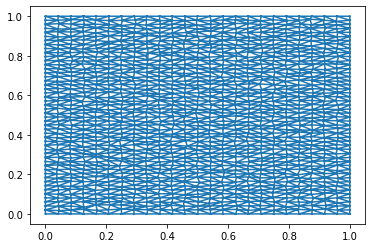

In [ ]:
pts = np.stack(np.meshgrid(np.linspace(0, 1, 25), np.linspace(0, 1, 50)))
noise =  np.random.normal(size=pts.shape, scale=.0025)
noise[:,0,:] = noise[:,-1,:] = 0
noise[:,:,0] = noise[:,:,-1] = 0

pts += noise
pts = pts.reshape((2, pts.shape[1]*pts.shape[2])).T

tri = spatial.Delaunay(pts)
plt.triplot(tri.points[:,0], tri.points[:,1], tri.simplices)

In [ ]:
%%time
test_mesh_large = ListOfVerticesAndFaces(tri.points, tri.simplices)

CPU times: user 116 ms, sys: 0 ns, total: 116 ms
Wall time: 114 ms


In [ ]:
%%time
_ = HalfEdgeMesh(test_mesh_large)
# ok!

CPU times: user 263 ms, sys: 0 ns, total: 263 ms
Wall time: 264 ms


In [ ]:
#| export
def get_test_mesh_large(x=np.linspace(0, 1, 25), y=np.linspace(0, 1, 50), noise=.0025):
    pts = np.stack(np.meshgrid(x, y))
    
    np.random.seed(1241) # get consistent results
    noise =  np.random.normal(size=pts.shape, scale=noise)
    noise[:,0,:] = noise[:,-1,:] = 0
    noise[:,:,0] = noise[:,:,-1] = 0
    pts += noise
    
    pts = pts.reshape((2, pts.shape[1]*pts.shape[2])).T
    tri = spatial.Delaunay(pts)
    return ListOfVerticesAndFaces(tri.points, tri.simplices)

def get_test_hemesh_large(x=np.linspace(0, 1, 25), y=np.linspace(0, 1, 50), noise=.0025):
    return HalfEdgeMesh(get_test_mesh_large(x=x, y=y, noise=noise))

In [ ]:
get_test_hemesh_large()

<__main__.HalfEdgeMesh>

## simple mesh traversal and modification algorithms

https://jerryyin.info/geometry-processing-algorithms/half-edge/

### required modification operations:

- Flip edge
- Collapse edge
- Split vertex

Other things should not really be required in the simulations. Adding/removing faces, vertices etc. should not happen, since initialization is not really meant to be incremental.

In [ ]:
# iterate around a face - not really required since we store all hes of a face

hemesh = get_test_hemesh()
fc = 0

returned = False
start_he = hemesh.faces[fc].hes[0]
he = start_he
while not returned:
    # do something here
    he = he.nxt
    returned = (he == start_he)
    
# iterating around a vertex (=dual face) is done by initializing with an inciden edge and using he.next.twin.

In [ ]:
# get all incident edges on vertex from a single one

hemesh = get_test_hemesh()
v = 0

returned = False
start_he = hemesh.vertices[v].incident[0]
he = start_he
while not returned:
    # do something here
    he = he.nxt.twin #hemesh.hes[hemesh.hes[he.nxt].twin]
    returned = (he == start_he)

### Update half edges of faces and vertices based on a single he

Re-create the full list of half edges belonging to a face or vertex based on its first half edge.
Useful for mesh modification operations

In [ ]:
#| export

@patch
def reset_hes(self: HalfEdgeMesh, face_or_vertex: Union[Face, Vertex]):
    """Re-create the full list of half edges belonging to a face or vertex based on its first half edge.
    Note: for vertices, this relies on the mesh being a triangulation. If that's not the case, would
    need use different method (go around face, with special case for bdry)."""
    returned = False
    new_hes = []
    if isinstance(face_or_vertex, Face):
        start_he = face_or_vertex.hes[0]
        he = start_he
        while not returned:
            he = he.nxt
            new_hes.append(he)
            returned = (he == start_he)
        face_or_vertex.hes = new_hes
    if isinstance(face_or_vertex, Vertex):
        start_he = face_or_vertex.incident[0]
        he = start_he
        while not returned:
            he = he.nxt.twin
            new_hes.append(he)
            returned = (he == start_he)
        face_or_vertex.incident = new_hes

In [ ]:
test_hemesh = get_test_hemesh()

print([x._heid for x  in test_hemesh.vertices[3].incident])
test_hemesh.vertices[3].incident = [test_hemesh.vertices[3].incident[2]]
print([x._heid for x  in test_hemesh.vertices[3].incident])
test_hemesh.reset_hes(test_hemesh.vertices[3])
print([x._heid for x  in test_hemesh.vertices[3].incident])


[1, 3, 8]
[8]
[1, 3, 8]


In [ ]:
test_hemesh = get_test_hemesh()

print([x._heid for x  in test_hemesh.faces[1].hes])
test_hemesh.faces[1].hes = [test_hemesh.faces[1].hes[2]]
print([x._heid for x  in test_hemesh.faces[1].hes])
test_hemesh.reset_hes(test_hemesh.faces[1])
print([x._heid for x  in test_hemesh.faces[1].hes])


[3, 4, 5]
[5]
[3, 4, 5]


#### Flip edge


Refer to https://jerryyin.info/geometry-processing-algorithms/half-edge/:

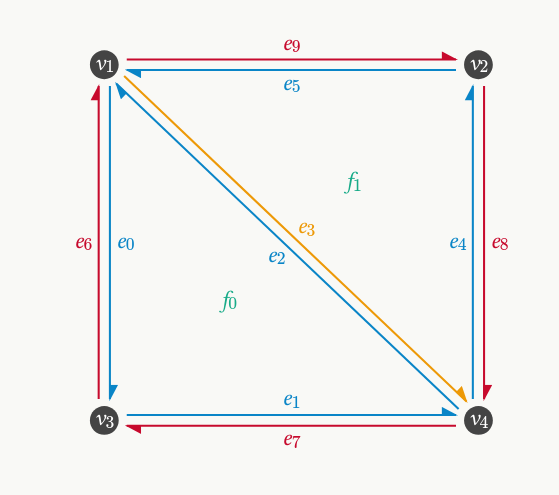

In [ ]:
#| export

@patch
def flip_edge(self: HalfEdgeMesh, e: int):
    """Flip edge of a triangle mesh. Call by using he index
    If the two adjacent faces are not triangles, it does not work!
    For variable name convention, see jerryyin.info/geometry-processing-algorithms/half-edge/"""
    # by convention, always flip the duplicate
    e = self.hes[e]
    e = e if e.duplicate else e.twin
    if e._faceid is None or e.twin._faceid is None:
        raise ValueError('Cannot flip boundary edge')
    # collect the required objects
    e5 = e.prev
    e4 = e.nxt
    twin = e.twin
    e1 = twin.prev
    e0 = twin.nxt
    # making sure the vertices and faces do not refer to any of the edges to be modified.
    f0, f1 = [e1.face, e5.face]
    f0.hes, f1.hes = [[e1], [e5]]
    v3, v4, v2, v1 = [he.vertices[1] for he in [e0, e1, e4, e5]]
    v3.incident, v4.incident, v2.incident, v1.incident = [[he] for he in [e0, e1, e4, e5]]
    # recycle e, twin.
    e._nxtid = e5._heid
    e._previd = e0._heid
    e._faceid = f1._fid
    e._verticesid = (v3._vid, v2._vid)
    twin._nxtid = e1._heid
    twin._previd = e4._heid
    twin._faceid = f0._fid
    twin._verticesid = (v2._vid, v3._vid)
    # update next/prev values for the external edges
    e0._nxtid = e._heid
    e1._nxtid = e4._heid
    e4._nxtid = twin._heid
    e5._nxtid = e0._heid
    e0._previd = e5._heid
    e1._previd = twin._heid
    e4._previd = e1._heid
    e5._previd = e._heid
    # update the face of e0, e4
    e0._faceid = f1._fid
    e4._faceid = f0._fid
    # re-complete the list of half-edges for the vertices and faces
    for vertex_or_face in [f0, f1]+[v3, v4, v2, v1]:
        self.reset_hes(vertex_or_face)
    # notifiy edge! return the _heid, or set "Flipped" or something!
    e.flipped, twin.flipped = (True, True)
    # re-order the faces
    f0.sort_hes(); f1.sort_hes()
    
        

In [ ]:
# external edges (face is None) should not change. twin values should not change. both those conditions ok

In [ ]:
test_hemesh = get_test_hemesh()

In [ ]:
# internal hes: 2, 3

{key: val for key, val in test_hemesh.hes.items() if val.face is not None}

{0: HalfEdge(heid=0, nxt=1, prev=2, twin=6, face=0, vertices=(0, 2), rest=0.0, passive=0.0, center=[0.5 0. ],
 1: HalfEdge(heid=1, nxt=2, prev=0, twin=7, face=0, vertices=(2, 3), rest=0.0, passive=0.0, center=[1.  0.5],
 2: HalfEdge(heid=2, nxt=0, prev=1, twin=3, face=0, vertices=(3, 0), rest=0.0, passive=0.0, center=[0.5 0.5],
 3: HalfEdge(heid=3, nxt=4, prev=5, twin=2, face=1, vertices=(0, 3), rest=0.0, passive=0.0, center=[0.5 0.5],
 4: HalfEdge(heid=4, nxt=5, prev=3, twin=8, face=1, vertices=(3, 1), rest=0.0, passive=0.0, center=[0.5 1. ],
 5: HalfEdge(heid=5, nxt=3, prev=4, twin=9, face=1, vertices=(1, 0), rest=0.0, passive=0.0, center=[0.  0.6]}

In [ ]:
{key: val.coords for key, val in test_hemesh.vertices.items()}

{0: array([0., 0.]),
 1: array([0. , 1.1]),
 2: array([1., 0.]),
 3: array([1., 1.])}

In [ ]:
test_hemesh.to_ListOfVerticesAndFaces().faces

{0: [0, 2, 3], 1: [0, 3, 1]}

In [ ]:
test_hemesh.flip_edge(2)

In [ ]:
{key: val for key, val in test_hemesh.hes.items() if val.face is not None}

{0: HalfEdge(heid=0, nxt=3, prev=5, twin=6, face=1, vertices=(0, 2), rest=0.0, passive=0.0, center=[0.5 0. ],
 1: HalfEdge(heid=1, nxt=4, prev=2, twin=7, face=0, vertices=(2, 3), rest=0.0, passive=0.0, center=[1.  0.5],
 2: HalfEdge(heid=2, nxt=1, prev=4, twin=3, face=0, vertices=(1, 2), rest=0.0, passive=0.0, center=[0.5 0.6],
 3: HalfEdge(heid=3, nxt=5, prev=0, twin=2, face=1, vertices=(2, 1), rest=0.0, passive=0.0, center=[0.5 0.6],
 4: HalfEdge(heid=4, nxt=2, prev=1, twin=8, face=0, vertices=(3, 1), rest=0.0, passive=0.0, center=[0.5 1. ],
 5: HalfEdge(heid=5, nxt=0, prev=3, twin=9, face=1, vertices=(1, 0), rest=0.0, passive=0.0, center=[0.  0.6]}

In [ ]:
{key: [he._heid for he in val.hes] for key, val in test_hemesh.faces.items()}

{0: [4, 2, 1], 1: [0, 3, 5]}

In [ ]:
test_hemesh.to_ListOfVerticesAndFaces().faces  # looks good to me !

{0: [2, 3, 1], 1: [0, 2, 1]}

In [ ]:
# how well does this perform?
test_hemesh_large = get_test_hemesh_large()

In [ ]:
%%time

for i in range(1000):
    heid = np.random.choice(list(test_hemesh_large.hes.keys()))
    try:
        test_hemesh_large.flip_edge(heid)
    except ValueError:
        continue

CPU times: user 671 ms, sys: 0 ns, total: 671 ms
Wall time: 647 ms


In [ ]:
#| export

@patch
def is_consistent(self: HalfEdgeMesh):
    """For debugging/testing purposes"""
    # check next and prev relations are consistent with vertices
    assert all([he.vertices[1] == he.nxt.vertices[0]
                and he.vertices[0] == he.prev.vertices[1]
                for he in self.hes.values()])
    # check half edges are registered in cells
    assert all([he in he.face.hes
                for he in self.hes.values() if he.face is not None])
    # check half edges are registered in vertices
    assert all([he in he.vertices[1].incident
                for he in self.hes.values()])
    # check twins have matching vertices
    assert all([he.vertices == he.twin.vertices[::-1]
                for he in self.hes.values()])
    # check everybody is a triangle
    assert all([len(fc.hes) == 3 for fc in self.faces.values()])
    # check all triangles are sorted
    assert all([all([(fc.hes[i].nxt == fc.hes[(i+1)%3]) for i in range(3)])
                for fc in self.faces.values()])
    
    return True

In [ ]:
# example of consistent and inconsistent meshes

In [ ]:
test_hemesh = get_test_hemesh()
print(test_hemesh.is_consistent())
test_hemesh.flip_edge(2)
print(test_hemesh.is_consistent())


True
True


In [ ]:
test_hemesh_large = get_test_hemesh_large()
print(test_hemesh_large.is_consistent())
test_hemesh_large.flip_edge(839)
print(test_hemesh_large.is_consistent())

True
True


In [ ]:
test_hemesh = get_test_hemesh()
test_hemesh.hes[0]._twinid = 0
try:
    test_hemesh.is_consistent()
    assert False, "should raise error"
except AssertionError:
    print("inconsistency detected, as desired")

test_hemesh = HalfEdgeMesh(test_mesh)

inconsistency detected, as desired


## Other mesh traversal related operations

In [ ]:
#| export

@patch
def is_bdr(self: Face):
    """True if face touches bdr. Check all vertices. Does any have an incident edge with None face?"""
    verts = [he.vertices[1] for he in self.hes]
    return any([any([he.face is None for he in v.incident]) for v in verts])

def get_boundary_faces(msh):
    """Get indices of boundary faces"""
    bdr_faces = []
    bdr_start = next(he for he in msh.hes.values() if he.face is None).twin.nxt
    he = bdr_start
    returned = False
    while not returned:
        bdr_faces.append(he.face._fid)
        if he.nxt.twin.face.is_bdr():
            he = he.nxt.twin
        else:
            he = he.prev.twin
        returned = (he == bdr_start)
    return bdr_faces

In [ ]:
#| export

@patch
def get_face_neighbors(self: Vertex):
    """Get face neighbors of vertex"""
    neighbors = []
    start_he = self.incident[0]
    he = start_he
    returned = False
    while not returned:
        neighbors.append(he.face)
        he = he.nxt.twin
        returned = (he == start_he)
    return neighbors


## Initializing the dual coordinates

In [ ]:
#| export

@patch
def set_centroid(self: HalfEdgeMesh):
    """Set dual positions to triangle centroid"""
    for fc in self.faces.values():
        vecs = []
        returned = False
        start_he = fc.hes[0]
        he = start_he
        while not returned:
            vecs.append(he.vertices[0].coords)
            he = he.nxt
            returned = (he == start_he)
        fc.dual_coords = np.mean(vecs, axis=0)

## transforming vertices and dual vertices

In [ ]:
#| export

@patch
def transform_vertices(self: HalfEdgeMesh, trafo: Union[Callable, NDArray[Shape["2, 2"], Float]]):
    for v in self.vertices.values():
        if isinstance(trafo, Callable):
            v.coords = trafo(v.coords)
        else:
            v.coords = trafo.dot(v.coords)
            
@patch
def transform_dual_vertices(self: HalfEdgeMesh, trafo: Union[Callable, NDArray[Shape["2, 2"], Float]]):
    for fc in self.faces.values():
        if isinstance(trafo, Callable):
            fc.dual_coords = trafo(fc.dual_coords)
        else:
            fc.dual_coords = trafo.dot(fc.dual_coords)

## Plotting functions

In [ ]:
#| export

@patch
def triplot(self: HalfEdgeMesh):
    """wraps plt.triplot"""
    list_format = self.to_ListOfVerticesAndFaces()
    fcs = np.array(list(list_format.faces.values()))
    pts = np.array(list(list_format.vertices.values())).T
    plt.triplot(pts[0], pts[1], fcs)
    
@patch
def labelplot(self: HalfEdgeMesh, vertex_labels=True, face_labels=True,
                     halfedge_labels=False, cell_labels=False):
    """for debugging purposes, a fct to plot a trimesh with labels attached"""
    if face_labels:
        for fc in self.faces.values():
            centroid = np.mean([he.vertices[0].coords for he in fc.hes], axis=0)
            plt.text(*centroid, str(fc._fid), color="k")
    if vertex_labels:
        for v in self.vertices.values():
            plt.text(*(v.coords+np.array([0,.05])), str(v._vid),
                     color="tab:blue", ha="center")
    if cell_labels:
        for v in self.vertices.values():
            nghbs = v.get_face_neighbors()
            if not (None in nghbs):
                center = np.mean([fc.dual_coords for fc in nghbs], axis=0)
                plt.text(*(center), str(v._vid),
                         color="tab:blue", ha="center")
    if halfedge_labels:
        for he in self.hes.values():
            if he.duplicate:
                centroid = np.mean([v.coords for v in he.vertices], axis=0)
                plt.text(*centroid, str(he._heid), color="tab:orange")
                
@patch
def cellplot(self: HalfEdgeMesh, alpha=1, set_lims=False):
    """Plot based on primal positions. Now fast because of use of LineCollection"""
    face_keys = sorted(self.faces.keys())
    face_key_dict = {key: ix for ix, key in enumerate(face_keys)}
    face_key_dict[None] = None
    primal_face_list = []
    for v in self.vertices.values():
        neighbors = v.get_face_neighbors()
        if not (None in neighbors):
            face = [face_key_dict[fc._fid] for fc in neighbors]
            face.append(face[0])
            primal_face_list.append(face)

    pts = np.stack([self.faces[key].dual_coords for key in face_keys])
    lines = [[pts[v] for v in fc] for fc in primal_face_list]
    
    #fig, ax = plt.subplots()
    plt.gca().add_collection(LineCollection(lines, color="k", alpha=alpha))
    if set_lims:
        plt.gca().set_xlim([pts[:,0].min(), pts[:,0].max()])
        plt.gca().set_ylim([pts[:,1].min(), pts[:,1].max()])

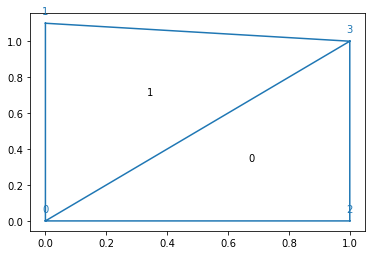

In [ ]:
test_hemesh = get_test_hemesh()
test_hemesh.set_centroid()
test_hemesh.triplot()
test_hemesh.labelplot()
test_hemesh.cellplot() # empty but that's just because there is no full cell

In [ ]:
test_hemesh.faces

{0: Face(fid=0, dual_coords=[0.7, 0.3], rest_shape=[[1.0, 0.0], [0.0, 1.0]], hes=[0, 1, 2]),
 1: Face(fid=1, dual_coords=[0.3, 0.7], rest_shape=[[1.0, 0.0], [0.0, 1.0]], hes=[3, 4, 5])}

In [ ]:
# important: preserve data! 

## Calculate internal angles and edge lengths

In [ ]:
#|export

@patch
def get_edge_lens(self: HalfEdgeMesh):
    return {key: np.linalg.norm(val.vertices[1].coords-val.vertices[0].coords)
            for key, val in self.hes.items()}

@patch
def set_rest_lengths(self: HalfEdgeMesh):
    for key, val in self.get_edge_lens().items():
        self.hes[key].rest = val
        
@patch
def get_rel_tension(self: HalfEdgeMesh):
    rel_tensions = {}
    for he in self.hes.values():
        surrounding = []
        if he.duplicate and he.face is not None:
            surrounding.append(he.nxt.rest)
            surrounding.append(he.prev.rest)
            twin = he.twin
            surrounding.append(twin.nxt.rest)
            surrounding.append(twin.prev.rest)
            rel_tensions[he._heid], rel_tensions[twin._heid] = 2*(4*he.rest/sum(surrounding),)
    return rel_tensions

In [ ]:
test_hemesh = get_test_hemesh()
test_hemesh.get_edge_lens()

{0: 1.0,
 6: 1.0,
 1: 1.0,
 7: 1.0,
 2: 1.4142135623730951,
 3: 1.4142135623730951,
 4: 1.004987562112089,
 8: 1.004987562112089,
 5: 1.1,
 9: 1.1}

In [ ]:
test_hemesh.set_rest_lengths()
test_hemesh.get_rel_tension()

{0: 0.8860901117618422,
 6: 0.8860901117618422,
 1: 0.905140971710352,
 7: 0.905140971710352,
 3: 1.3780441874425142,
 2: 1.3780441874425142}

In [ ]:
test_hemesh.set_rest_lengths(); {key: val.rest for key, val in test_hemesh.hes.items()}

{0: 1.0,
 6: 1.0,
 1: 1.0,
 7: 1.0,
 2: 1.4142135623730951,
 3: 1.4142135623730951,
 4: 1.004987562112089,
 8: 1.004987562112089,
 5: 1.1,
 9: 1.1}

## Export code to module

In [ ]:
#| hide

nbdev.nbdev_export()